In [11]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import json

In [ ]:
from shapely.geometry import Polygon
# Cargar el archivo JSON
json_path = "Poligonos/RM_Json.json"
with open(json_path) as f:
    data = json.load(f)

# Filtrar las comunas con "estudio" igual a 1
filtered_features = [feature for feature in data["features"] if feature["attributes"]["estudio"] == 1]

# Convertir las geometrías a objetos shapely
geometries = [Polygon(feature["geometry"]["rings"][0]) for feature in filtered_features]
attributes = [feature["attributes"] for feature in filtered_features]

# Crear el GeoDataFrame
gdf = gpd.GeoDataFrame(attributes, geometry=geometries)

# Cargar el archivo Excel
excel_path = "filtered_tmax.xlsx"
df = pd.read_excel(excel_path)

In [18]:
df.head

<bound method NDFrame.head of        year  month  day  Santiago  Cerrillos  Cerro Navia  Conchali  \
0      1990      1    1    32.024     32.769       33.181    32.473   
1      1990      1    2    31.648     32.211       32.626    32.070   
2      1990      1    3    32.867     33.654       34.035    33.274   
3      1990      1    4    33.482     34.142       34.525    33.926   
4      1990      1    5    33.260     34.010       34.369    33.672   
...     ...    ...  ...       ...        ...          ...       ...   
11310  2020     12   27    29.509     30.064       30.555    29.909   
11311  2020     12   28    30.895     31.525       31.913    31.186   
11312  2020     12   29    27.726     28.542       29.077    28.121   
11313  2020     12   30    32.028     32.780       33.157    32.250   
11314  2020     12   31    32.704     33.114       33.484    33.000   

       El Bosque  Estacion Central  Huechuraba  ...  Providencia  Pudahuel  \
0         31.871            32.819     

[Cálculo de percentiles:](https://numpy.org/doc/2.1/reference/generated/numpy.percentile.html)

In [14]:
percentiles = df.iloc[:, 3:].apply(lambda x: np.percentile(x.dropna(), [90, 95, 99]), axis=0)

In [34]:
percentiles

,Santiago,Cerrillos,Cerro Navia,Conchali,El Bosque,Estacion Central,Huechuraba,Independencia,La Cisterna,La Florida,...,Providencia,Pudahuel,Quilicura,Quinta Normal,Recoleta,Renca,San Joaquin,San Miguel,San Ramon,Vitacura
0,31.28700,31.90800,32.33360,31.60620,31.08900,31.99300,30.1298,31.37580,31.12720,27.83320,...,30.65520,31.17560,32.28100,31.86800,30.62160,32.1436,31.13660,31.19220,30.91700,29.59040
1,32.29700,32.94900,33.35310,32.59000,32.12530,32.99460,31.1070,32.36700,32.14830,28.83230,...,31.63660,32.19890,33.25330,32.87830,31.61630,33.1486,32.15830,32.19830,31.95100,30.56560
2,34.08332,34.79878,35.17286,34.39358,34.02986,34.85116,32.8750,34.16916,34.01786,30.68372,...,33.41658,34.04988,35.10658,34.72186,33.40002,34.9973,33.99672,34.06004,33.84822,32.32674


In [33]:
percentiles["Lo Barnechea"]

0    19.21800
1    20.25660
2    22.03586
Name: Lo Barnechea, dtype: float64

In [9]:
# Función para identificar olas de calor
def identificar_olas_de_calor(temperaturas, percentiles, umbral=30):
    olas = {
        '>=30 grados': (temperaturas >= umbral).astype(int),
        '>=percentile 90': (temperaturas >= percentiles[0]).astype(int),
        '>=percentile 95': (temperaturas >= percentiles[1]).astype(int),
        '>=percentile 99': (temperaturas >= percentiles[2]).astype(int)
    }
    return olas

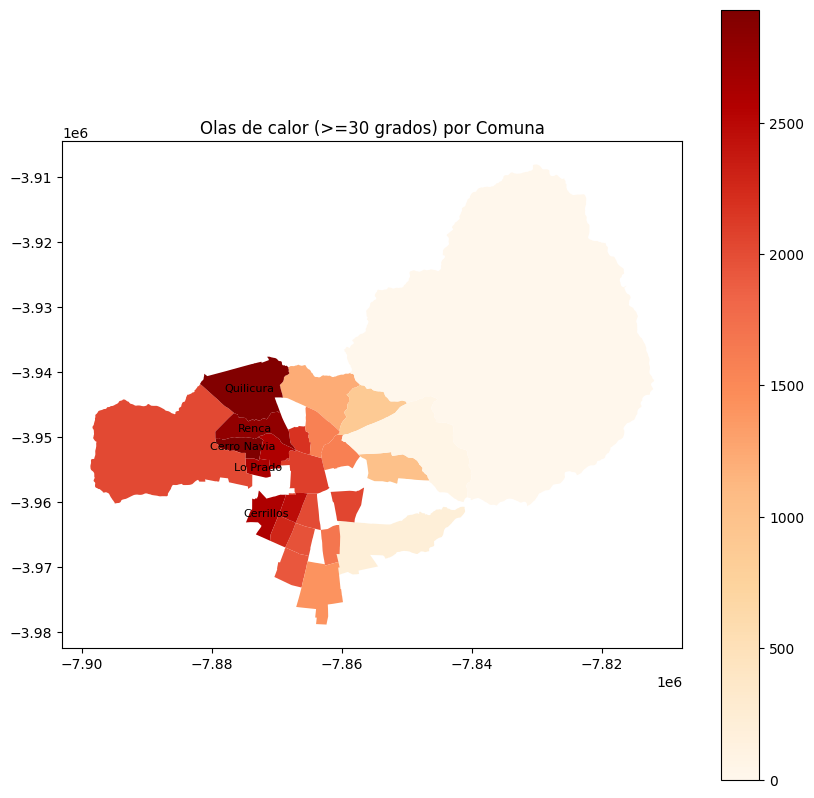

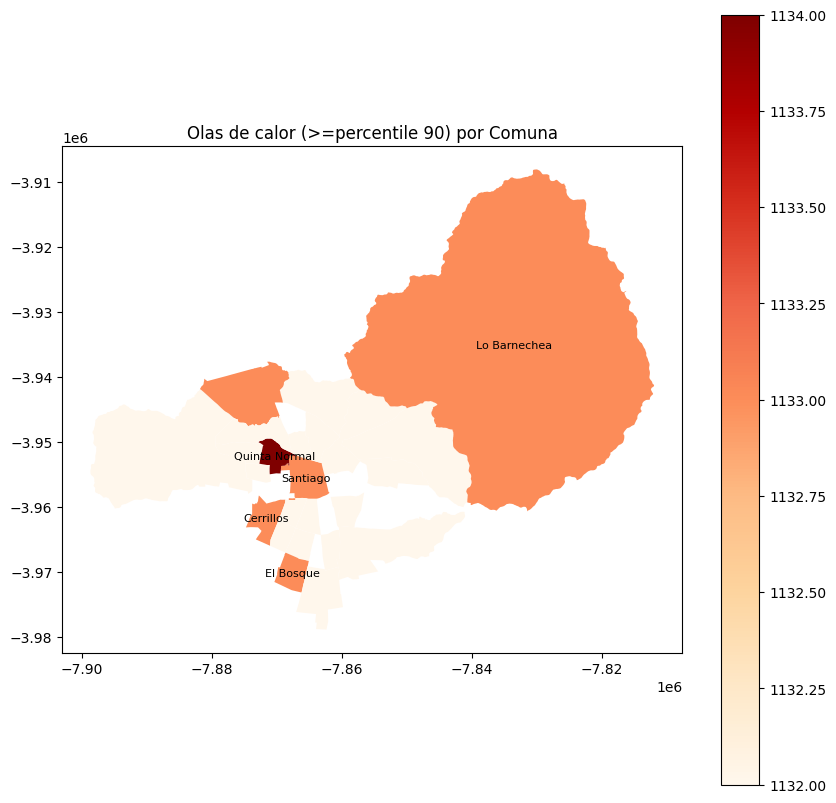

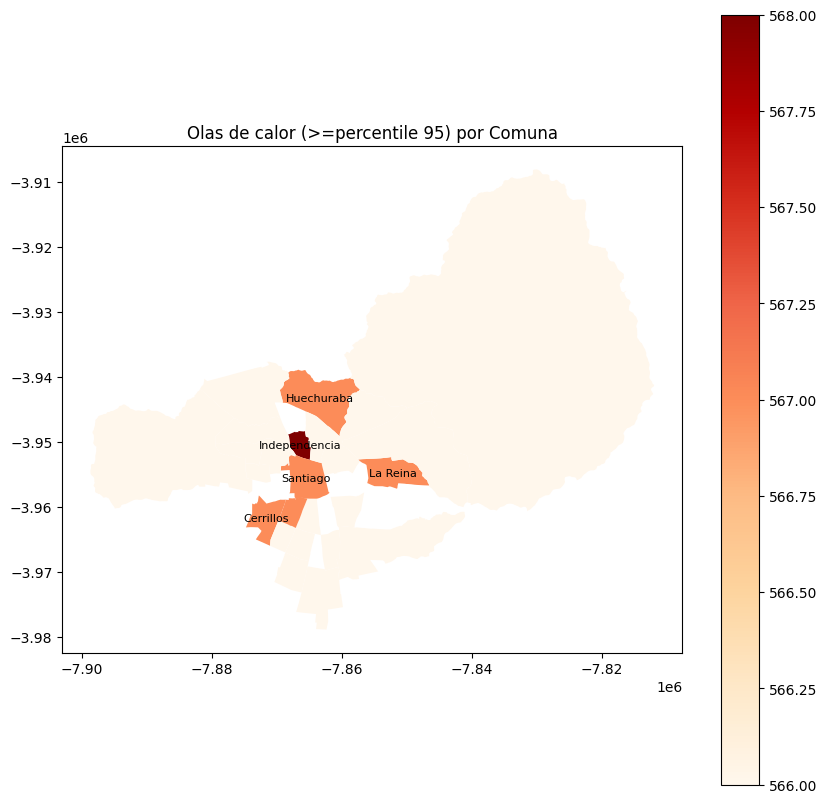

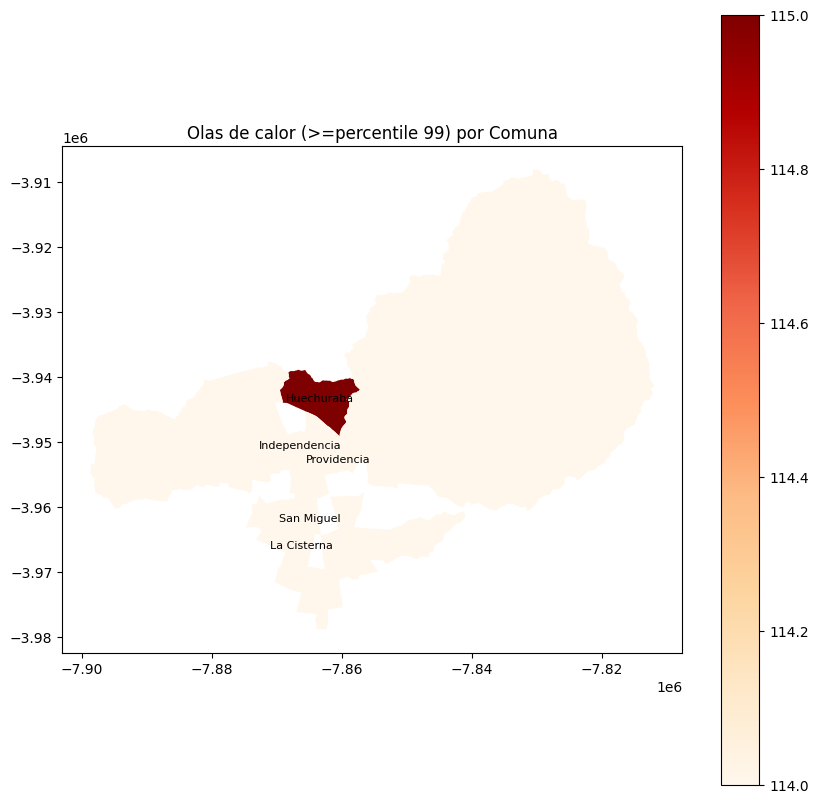

In [21]:
olas_de_calor = {}
for comuna in df.columns[3:]:
    temperaturas = df[comuna]
    olas_de_calor[comuna] = identificar_olas_de_calor(temperaturas, percentiles[comuna])

# Ccantidad de olas de calor por comuna
olas_de_calor_contadas = {comuna: {key: sum(value) for key, value in olas.items()} for comuna, olas in olas_de_calor.items()}
olas_df = pd.DataFrame(olas_de_calor_contadas).T.reset_index().rename(columns={'index': 'Comuna'})

# Unir los datos del shapefile con los datos de las olas de calor
merged = gdf.merge(olas_df, left_on="Comuna", right_on="Comuna")

# gráficos para cada tipo de ola de calor
for tipo_ola in ['>=30 grados', '>=percentile 90', '>=percentile 95', '>=percentile 99']:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    merged.plot(column=tipo_ola, ax=ax, legend=True, cmap='OrRd')

    # Obtener las 5 comunas con mayor cantidad de olas de calor
    top_5_comunas = merged.nlargest(5, tipo_ola)

    # Añadir nombres de las 5 comunas con mayor cantidad de olas de calor
    for x, y, label in zip(top_5_comunas.geometry.centroid.x, top_5_comunas.geometry.centroid.y, top_5_comunas['Comuna']):
        ax.text(x, y, label, fontsize=8, ha='center', va='center')

    plt.title(f'Olas de calor ({tipo_ola}) por Comuna')
    plt.show()

In [16]:
# Imprimir la cantidad de olas de calor por comuna
print(olas_df)

                 Comuna  >=30 grados  >=percentile 90  >=percentile 95  \
0              Santiago         2095             1133              567   
1             Cerrillos         2593             1133              567   
2           Cerro Navia         2931             1132              566   
3              Conchali         2360             1132              567   
4             El Bosque         1927             1133              566   
5      Estacion Central         2677             1133              566   
6            Huechuraba         1220             1132              567   
7         Independencia         2177             1132              568   
8           La Cisterna         1964             1132              566   
9            La Florida          217             1132              566   
10            La Granja         1675             1132              566   
11           La Pintana         1419             1132              566   
12             La Reina         1016  

Agregar dias consecutivos de HW: 3 días consecutivos

# EXcess Heat Factor (EHF)

In [ ]:
def EHF(data, tmax_col, tmin_col, date_col, p_col, n_days=3, period_days=30):
    # Verificar columnas
    required_cols = [tmax_col, tmin_col, date_col, p_col]
    if not all(col in data.columns for col in required_cols):
        raise ValueError("Error: Una o más columnas especificadas no existen en los datos.")

    # Ordenar los datos por fecha para asegurar la secuencia
    data = data.sort_values(by=date_col)

    # Calcular temperatura media ajustada (tad)
    data['TAD'] = (data[tmax_col] + data[tmin_col].shift(-1)) / 2

    # Calcular TAD_p95 por grupo y agregarlo al marco de datos original
    data['TAD_p95'] = data.groupby('com')['TAD'].transform(lambda x: x.quantile(0.95))

    # Calcular EHIsigi, EHIaccli y EHF para `TAD` y `tmax`
    data['EHIsigi_tad'] = data['TAD'].rolling(window=n_days).mean() - data['TAD_p95']
    data['EHIaccli_tad'] = data['TAD'].rolling(window=n_days).mean() - data['TAD'].rolling(window=period_days).mean()
    data['EHF_tad'] = data['EHIsigi_tad'] * np.maximum(1, data['EHIaccli_tad'])

    data['EHIsigi_tmax'] = data[tmax_col].rolling(window=n_days).mean() - data[p_col]
    data['EHIaccli_tmax'] = data[tmax_col].rolling(window=n_days).mean() - data[tmax_col].rolling(window=period_days).mean()
    data['EHF_tmax'] = data['EHIsigi_tmax'] * np.maximum(1, data['EHIaccli_tmax'])

    return data


## Contar 3 días consecutivos de olas de calor para cada definición


In [24]:

# Función para contar olas de calor de 3 días consecutivos
def contar_olas_consecutivas(olas, dias=3):
    conteo = 0
    for i in range(len(olas) - dias + 1):
        if all(olas[i:i + dias]):
            conteo += 1
    return conteo

# Identificar olas de calor para cada comuna
olas_de_calor = {}
for comuna in df.columns[3:]:
    temperaturas = df[comuna]
    olas_de_calor[comuna] = identificar_olas_de_calor(temperaturas, percentiles[comuna])

# Contar la cantidad de olas de calor por comuna y por condición
olas_de_calor_contadas = {}
olas_de_calor_consecutivas = {}
for comuna, olas in olas_de_calor.items():
    olas_de_calor_contadas[comuna] = {key: sum(value) for key, value in olas.items()}
    olas_de_calor_consecutivas[comuna] = {key: contar_olas_consecutivas(value) for key, value in olas.items()}

# Convertir a DataFrame
olas_df = pd.DataFrame(olas_de_calor_contadas).T.reset_index().rename(columns={'index': 'Comuna'})
olas_consecutivas_df = pd.DataFrame(olas_de_calor_consecutivas).T.reset_index().rename(columns={'index': 'Comuna'})

# Unir los datos del GeoDataFrame con los datos de las olas de calor
merged = gdf.merge(olas_df, left_on="Comuna", right_on="Comuna")
merged_consecutivas = gdf.merge(olas_consecutivas_df, left_on="Comuna", right_on="Comuna")

# Imprimir la cantidad de olas de calor de 3 días consecutivos por comuna y por condición
print("Cantidad de olas de calor de 3 días consecutivos por comuna y por condición:")
print(olas_consecutivas_df)

Cantidad de olas de calor de 3 días consecutivos por comuna y por condición:
                 Comuna  >=30 grados  >=percentile 90  >=percentile 95  \
0              Santiago         1024              379              132   
1             Cerrillos         1473              358              114   
2           Cerro Navia         1784              363              119   
3              Conchali         1284              380              132   
4             El Bosque          868              355              119   
5      Estacion Central         1557              367              117   
6            Huechuraba          433              390              142   
7         Independencia         1113              385              136   
8           La Cisterna          899              358              121   
9            La Florida           35              403              153   
10            La Granja          709              371              133   
11           La Pintana          52

In [ ]:
from EHF.EHF_Fuction import calculate_ehf